In [1]:
import numpy as np
import pandas as pd
#import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import seaborn as sns
sns.set()

from sklearn.neighbors import NearestNeighbors

from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

C:\Users\jonat\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Se visualiza los datos y se elimina las columnas que no son necesarias

In [2]:
dfRead = pd.read_csv('Suma_todasLasSesiones.csv')
df = dfRead.drop(['Sesion','Id'], axis=1)
#df = df[df['Fsm']!=0]

## Filtrado de datos

## Histograma de las notas

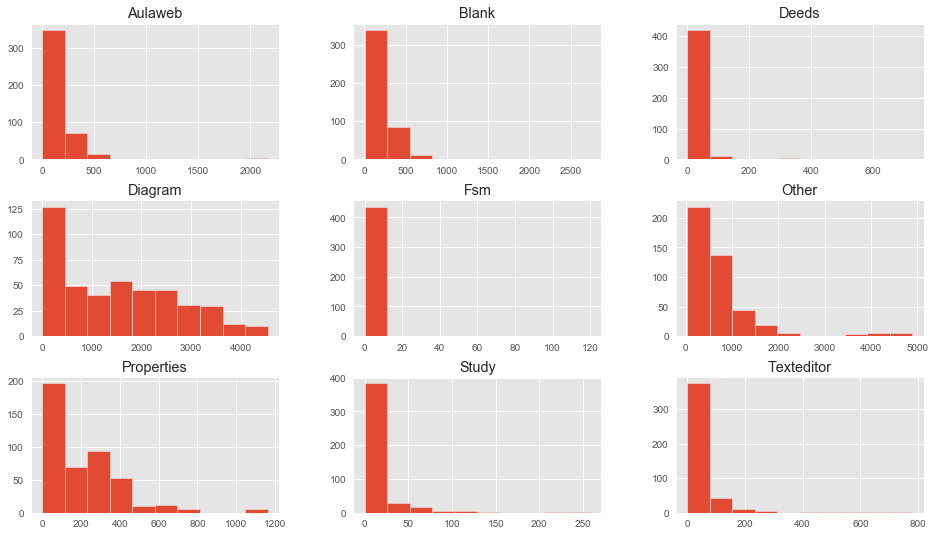

In [3]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
datos = df.drop(['Nota'],1).hist()
plt.grid(True)
plt.show()

## Se crean los datos para el clusters y las categorias


In [4]:
clusters = df[['Nota']]
X = df.drop(['Nota'],1)

In [5]:
## Se reliza la normalización de los datos para que esten en un rango de (0,1)
scaler = MinMaxScaler(feature_range=(0, 1))
x = scaler.fit_transform(X)


## Se definen los metodos a emplear en el cluster

In [6]:
def clusterDBscan(x):
    db = cluster.DBSCAN(eps=0.175, min_samples=5)
    db.fit(x)
    return db.labels_


def clusterKMeans(x, n_clusters):
    return cluster.k_means(x, n_clusters=n_clusters)[1]

## Se crea funciones en caso de ser necesarias para poder reducir las dimensiones

In [7]:
def reducir_dim(x, ndim):
    pca = PCA(n_components=ndim)
    return pca.fit_transform(x)


def reducir_dim_tsne(x, ndim):
    pca = TSNE(n_components=ndim)
    return pca.fit_transform(x)

## Se grafica los valores de los posibles cluster en base a silohuette score

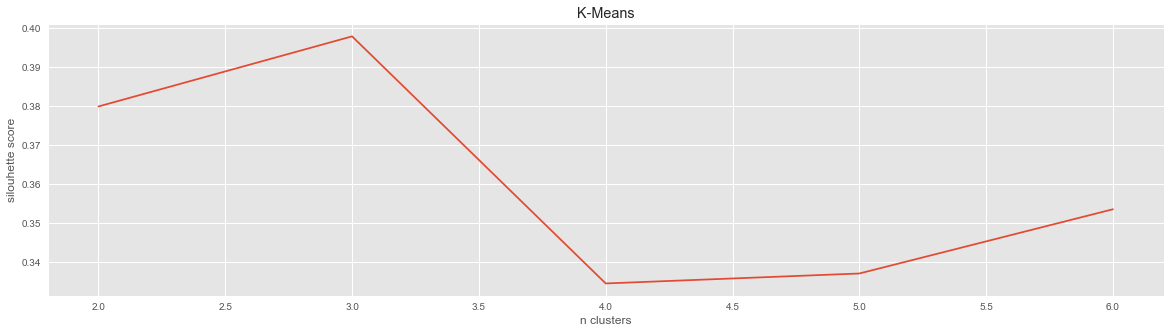

In [8]:
def calculaSilhoutter(x, clusters):
    res=[]
    fig, ax = plt.subplots(1,figsize=(20, 5))
    for numCluster in range(2, 7):
        res.append(silhouette_score(x, clusterKMeans(x,numCluster )))
            
    ax.plot(range(2, 7), res)
    ax.set_xlabel("n clusters")
    ax.set_ylabel("silouhette score")
    ax.set_title("K-Means")


calculaSilhoutter(x, clusters)

## Se grafica los valores de los posibles cluster en base a Elbow Method

C:\Users\jonat\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jonat\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jonat\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


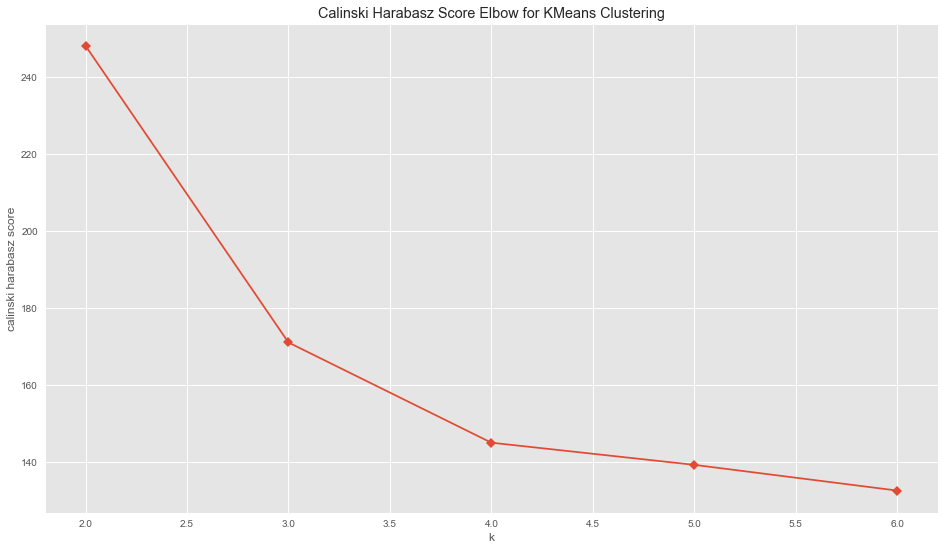

In [9]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,7), metric='calinski_harabasz', timings=False)

visualizer.fit(x)        # Fit the data to the visualizer
visualizer.show()  

In [10]:
clus_km = clusterKMeans(x, 3)
clus_db = clusterDBscan(x)

def reducir_dataset(x, how):
    if how == "pca":
        res = reducir_dim(x, ndim=2)
    elif how == "tsne":
        res = reducir_dim_tsne(x, ndim=2)
    else:
        return x[:, :2]

    return res

In [11]:
results = pd.DataFrame(np.column_stack([reducir_dataset(x, how="tsne"), clusters, clus_km, clus_db]), columns=["x", "y", "clusters", "clus_km", "clus_db"])


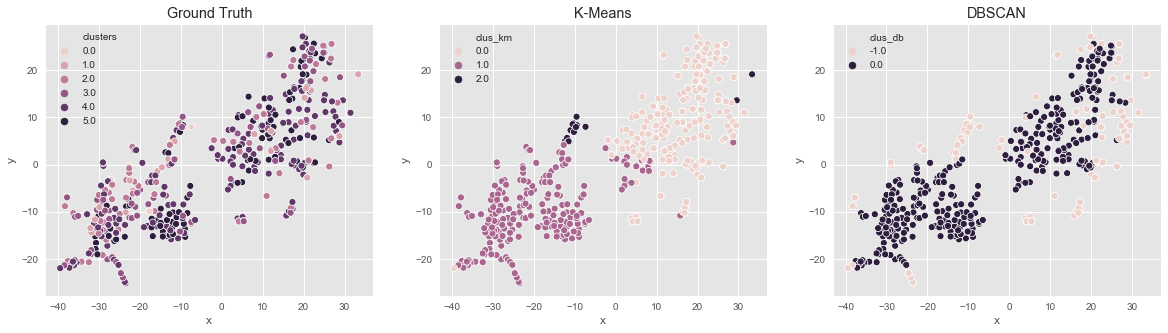

In [12]:
def mostrar_resultados(res):
    """Muestra los resultados de los algoritmos
    """
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    sns.scatterplot(data=res, x="x", y="y", hue="clusters", ax=ax[0], legend="full")
    ax[0].set_title('Ground Truth')
    
    sns.scatterplot(data=res, x="x", y="y", hue="clus_km", ax=ax[1], legend="full")
    ax[1].set_title('K-Means')
    
    sns.scatterplot(data=res, x="x", y="y", hue="clus_db", ax=ax[2], legend="full")
    ax[2].set_title('DBSCAN')
    

mostrar_resultados(results)

In [13]:
kmeans = KMeans(n_clusters=3,init = "k-means++")
kmeans.fit(x)

KMeans(n_clusters=3)

In [14]:
labels = kmeans.predict(x)
X['Cluster_Km']=labels
dfRead['Cluster_Km']=labels

In [15]:
X.groupby('Cluster_Km').mean()

,Study,Deeds,Texteditor,Diagram,Properties,Other,Blank,Aulaweb,Fsm
Cluster_Km,,,,,,,,,
0,14.557078,14.712329,58.525114,2470.794521,338.456621,724.894977,259.442922,209.447489,2.305936
1,8.227053,16.748792,19.043478,458.362319,34.458937,498.043478,156.855072,118.405797,0.028986
2,23.705882,7.352941,42.000000,2303.176471,351.529412,4136.352941,86.294118,216.117647,0.470588


## DBSCAN

In [16]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(x)
distances, indices = nbrs.kneighbors(x)

(0, 0.25)

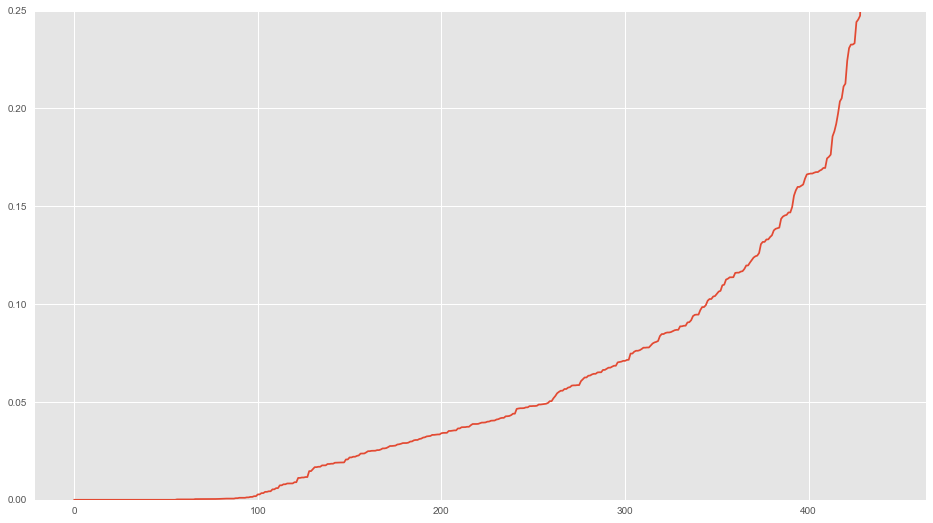

In [17]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.ylim(0,0.25)

In [18]:
dbscan = cluster.DBSCAN(eps=0.175, min_samples=5)
dbscan.fit(x)

DBSCAN(eps=0.175)

In [19]:
clusterDbscan = dbscan.labels_
X['Cluster_DB']=clusterDbscan
dfRead['Cluster_DB']=clusterDbscan
X.groupby('Cluster_DB').mean()

,Study,Deeds,Texteditor,Diagram,Properties,Other,Blank,Aulaweb,Fsm,Cluster_Km
Cluster_DB,,,,,,,,,,
-1,28.636364,27.709091,107.718182,2047.672727,308.900000,1300.209091,340.963636,325.836364,4.236364,0.527273
0,6.438438,11.309309,16.888889,1351.036036,159.915916,567.993994,159.903904,114.747748,0.159159,0.549550


In [21]:
dfRead

,Sesion,Id,Study,Deeds,Texteditor,Diagram,Properties,Other,Blank,Aulaweb,Fsm,Nota,Cluster_Km,Cluster_DB
0,2,1,1.0,1.0,3.0,782.0,27.0,149.0,39.0,6.0,0.0,4.0,1,0
1,2,2,1.0,72.0,10.0,157.0,36.0,176.0,47.0,18.0,0.0,3.0,1,0
2,2,3,1.0,2.0,103.0,195.0,3.0,198.0,95.0,21.0,0.0,3.0,1,0
3,2,4,1.0,2.0,4.0,143.0,2.0,582.0,153.0,48.0,1.0,5.0,1,0
4,2,5,1.0,3.0,6.0,189.0,22.0,118.0,65.0,46.0,0.0,4.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,6,97,1.0,1.0,5.0,1663.0,337.0,788.0,94.0,225.0,1.0,1.0,0,0
439,6,98,1.0,2.0,10.0,2812.0,336.0,761.0,24.0,0.0,2.0,4.0,0,0
440,6,99,11.0,3.0,215.0,2952.0,194.0,797.0,210.0,123.0,0.0,2.0,0,-1
441,6,102,2.0,11.0,245.0,785.0,1.0,570.0,115.0,48.0,0.0,2.0,1,-1
